# Mask R-CNN - Train on Shapes Dataset


This notebook shows how to train Mask R-CNN on your own dataset. To keep things simple we use a synthetic dataset of shapes (squares, triangles, and circles) which enables fast training. You'd still need a GPU, though, because the network backbone is a Resnet101, which would be too slow to train on a CPU. On a GPU, you can start to get okay-ish results in a few minutes, and good results in less than an hour.

The code of the *Shapes* dataset is included below. It generates images on the fly, so it doesn't require downloading any data. And it can generate images of any size, so we pick a small image size to train faster. 

In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt

from config import Config
import utils
import model as modellib
import visualize
from model import log

# rla IJ mask and roi functions
import ij_mask_roi

%matplotlib inline 

# Root directory of the project
ROOT_DIR = os.getcwd()

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Path to COCO trained weights
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco_weights.h5")

Using TensorFlow backend.


## Configurations

In [2]:
class imgConfig(Config):
    """Configuration for training.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "shapes"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 8

    # Number of classes (including background)
    NUM_CLASSES = 1 + 3  # background + 3 shapes

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 3884
    IMAGE_MAX_DIM = 3892

    # Use smaller anchors because our image and objects are small
    #RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 1000

    # Use a small epoch since the data is simple
    #STEPS_PER_EPOCH = 100

    # use small validation steps since the epoch is small
    #VALIDATION_STEPS = 5
    
config = imgConfig()
config.display()


Configurations:
BACKBONE_SHAPES                [[973 973]
 [487 487]
 [244 244]
 [122 122]
 [ 61  61]]
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     8
BBOX_STD_DEV                   [ 0.1  0.1  0.2  0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
IMAGES_PER_GPU                 8
IMAGE_MAX_DIM                  3892
IMAGE_MIN_DIM                  3884
IMAGE_PADDING                  True
IMAGE_SHAPE                    [3892 3892    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [ 123.7  116.8  103.9]
MINI_MASK_SHAPE                (56, 56)
NAME                           shapes
NUM_CLASSES                    4
POOL_SIZE                      7
POST_NMS_ROIS_INFERENCE        1000
POST_NMS_ROIS_TRAI

## Notebook Preferences

In [3]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Dataset

Create a synthetic dataset

Extend the Dataset class and add a method to load the shapes dataset, `load_shapes()`, and override the following methods:

* load_image()
* load_mask()
* image_reference()

In [4]:
path = 'rla/images/train/'
files = os.listdir(path)
image_files = []
for file in files:
    
    if file.endswith('.tif') and 'mask' not in file:
        fl = os.path.join(ROOT_DIR, path + file)
        print(fl)
        image_files.append(file)
print(len(image_files))

/home/rla/deeplearn/mask_rcnn/rla/images/train/10-3 Mock_1001_processed.tif
/home/rla/deeplearn/mask_rcnn/rla/images/train/10-1 UBFsi_1007_processed.tif
/home/rla/deeplearn/mask_rcnn/rla/images/train/10-1 mock_1004_processed.tif
/home/rla/deeplearn/mask_rcnn/rla/images/train/Parental cMYCsi_1002_processed.tif
/home/rla/deeplearn/mask_rcnn/rla/images/train/10-1 mock_1005_processed.tif
/home/rla/deeplearn/mask_rcnn/rla/images/train/10-1 mock_1003_processed.tif
/home/rla/deeplearn/mask_rcnn/rla/images/train/10-3 cMYC si_1002_processed.tif
/home/rla/deeplearn/mask_rcnn/rla/images/train/10-3 Mock_1002_processed.tif
/home/rla/deeplearn/mask_rcnn/rla/images/train/Parental cMYCsi_1_processed.tif
/home/rla/deeplearn/mask_rcnn/rla/images/train/10-1 cMYCsi_1001_processed.tif
/home/rla/deeplearn/mask_rcnn/rla/images/train/Parental untr_1001_processed.tif
/home/rla/deeplearn/mask_rcnn/rla/images/train/10-2 cUBFsi_1002_processed.tif
/home/rla/deeplearn/mask_rcnn/rla/images/train/10-1 UBFsi_1006_proc

In [7]:
class imgDataset(utils.Dataset):
    """
    Load images from file and generate object instance masks 
    from IJ masks and roi.zip files
    """

    def add_images(self, image_dir, height, width):
        """
        Add image path info from directory
        INPUT:
            image_dir: Directory containing images, masks, and roi.zip files
            height: image height
            width: image width
        OUTPUT:
            NONE
            Adds image info to the Dataset class to be called later
        """
        # Add classes
        dataset_name = 'cells'
        self.add_class(dataset_name, 1, "nucleus")
        self.add_class(dataset_name, 2, "nucleolus")

        # Add .tif images
        # Path of mask and ROI in image info
        for i, file in enumerate(files):
            if file.endswith('.tif') and 'mask' not in file:
                img_path = os.path.join(ROOT_DIR, image_dir + file)
                print(img_path)
                mask_path = os.path.splitext(img_path)[0] + '_mask.tif'
                roi_path = os.path.splitext(img_path)[0] + '1.zip'
                print(mask_path)
                if os.path.isfile(mask_path) and os.path.isfile(roi_path):
                    print(file)
                    self.add_image(dataset_name, image_id=i, path=img_path,
                                   width=width, height=height,
                                   mask_path=mask_path, roi_path=roi_path,
                                   )
        print('{} images added.'.format(len(self.image_info)))

    def load_image(self, image_id):
        """
        Load image from image_info dictionary
        """
        info = self.image_info[image_id]
        image = ij_mask_roi.openTifImage(info['path'])
        
        return image

    def load_mask(self, image_id):
        """
        Generate instance masks using IJ masks and roi.zip for the given image ID.
        """
        info = self.image_info[image_id]
        mask_arrays, mask_classes = ij_mask_roi.getMaskObjects(info['mask_path'], 1)
        roi_arrays, roi_classes = ij_mask_roi.getROIobjects(info['roi_path'], 2, info['height'], info['width'])
        masks = np.append(mask_arrays, roi_arrays, axis=2)
        class_ids = np.append(mask_classes, roi_classes)
        
        return masks, class_ids.astype(np.int32)


In [8]:
"""
RLA TESTING SHAPES DATASET
See how masks are formatted
"""
dataset_test = imgDataset()
dataset_test.add_images('rla/images/train/',3884,3892)
dataset_test.prepare()

/home/rla/deeplearn/mask_rcnn/rla/images/train/10-3 Mock_1001_processed.tif
/home/rla/deeplearn/mask_rcnn/rla/images/train/10-3 Mock_1001_processed_mask.tif
10-3 Mock_1001_processed.tif
/home/rla/deeplearn/mask_rcnn/rla/images/train/10-1 UBFsi_1007_processed.tif
/home/rla/deeplearn/mask_rcnn/rla/images/train/10-1 UBFsi_1007_processed_mask.tif
10-1 UBFsi_1007_processed.tif
/home/rla/deeplearn/mask_rcnn/rla/images/train/10-1 mock_1004_processed.tif
/home/rla/deeplearn/mask_rcnn/rla/images/train/10-1 mock_1004_processed_mask.tif
10-1 mock_1004_processed.tif
/home/rla/deeplearn/mask_rcnn/rla/images/train/Parental cMYCsi_1002_processed.tif
/home/rla/deeplearn/mask_rcnn/rla/images/train/Parental cMYCsi_1002_processed_mask.tif
Parental cMYCsi_1002_processed.tif
/home/rla/deeplearn/mask_rcnn/rla/images/train/10-1 mock_1005_processed.tif
/home/rla/deeplearn/mask_rcnn/rla/images/train/10-1 mock_1005_processed_mask.tif
10-1 mock_1005_processed.tif
/home/rla/deeplearn/mask_rcnn/rla/images/train/10

In [23]:
msk, cls = dataset_test.load_mask(1)

(3884, 3892)


In [40]:
print(msk.shape)
mask2 = np.rollaxis(msk,2)

(3884, 3892, 257)


In [20]:
dataset_test.image_info[0]

{'height': 3884,
 'id': 4,
 'mask_path': '/home/rla/deeplearn/mask_rcnn/rla/images/train/10-3 Mock_1001_processed_mask.tif',
 'path': '/home/rla/deeplearn/mask_rcnn/rla/images/train/10-3 Mock_1001_processed.tif',
 'roi_path': '/home/rla/deeplearn/mask_rcnn/rla/images/train/10-3 Mock_1001_processed1.zip',
 'source': 'cells',
 'width': 3892}

0 (3884, 3892)


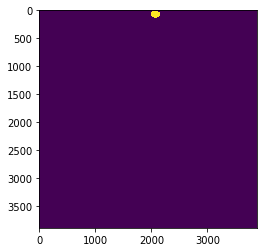

1 (3884, 3892)


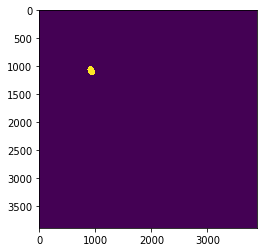

2 (3884, 3892)


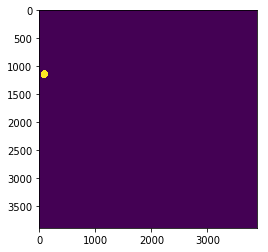

3 (3884, 3892)


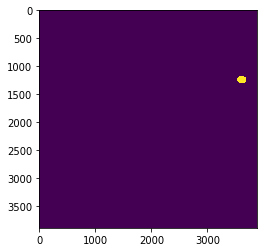

4 (3884, 3892)


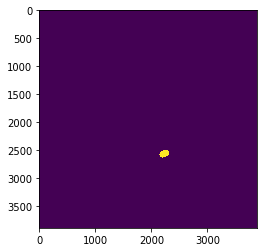

5 (3884, 3892)


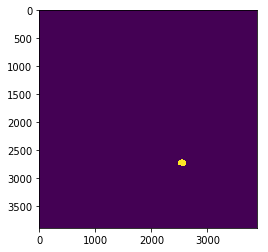

6 (3884, 3892)


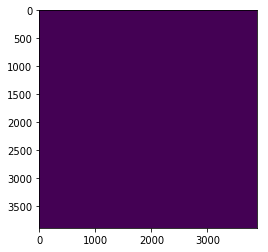

7 (3884, 3892)


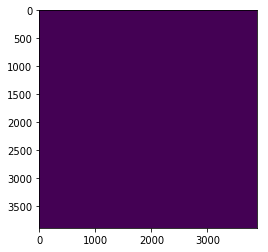

8 (3884, 3892)


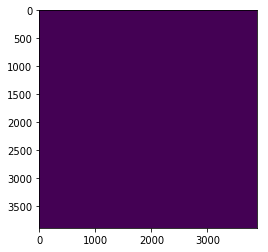

9 (3884, 3892)


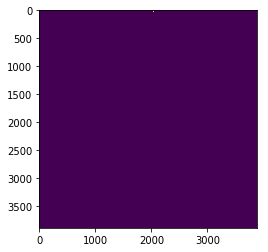

10 (3884, 3892)


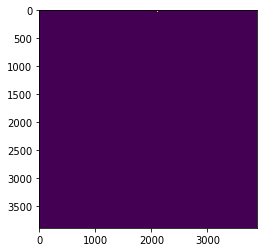

11 (3884, 3892)


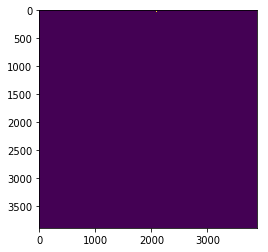

12 (3884, 3892)


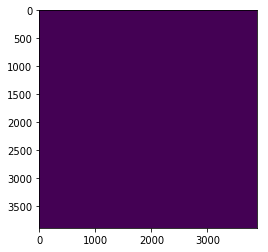

13 (3884, 3892)


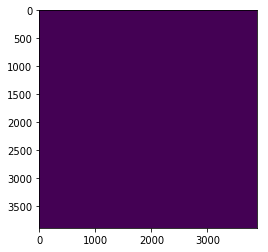

14 (3884, 3892)


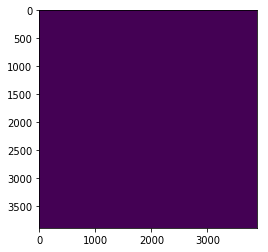

15 (3884, 3892)


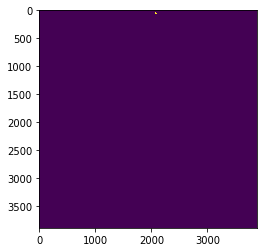

16 (3884, 3892)


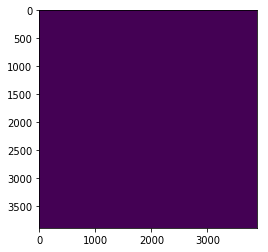

17 (3884, 3892)


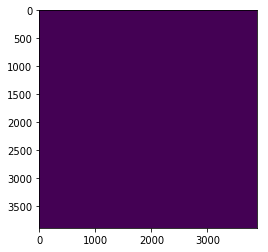

18 (3884, 3892)


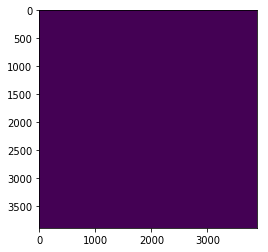

19 (3884, 3892)


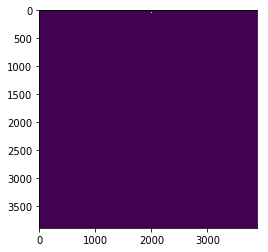

20 (3884, 3892)


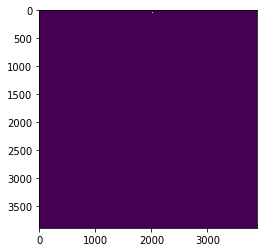

21 (3884, 3892)


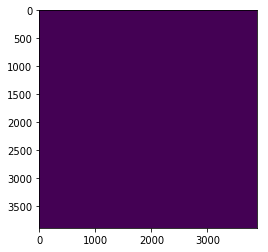

22 (3884, 3892)


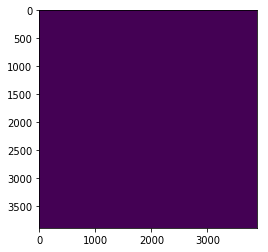

23 (3884, 3892)


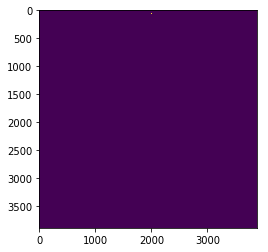

24 (3884, 3892)


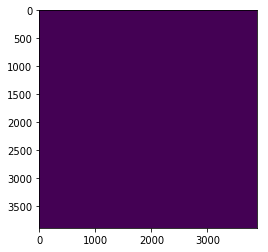

25 (3884, 3892)


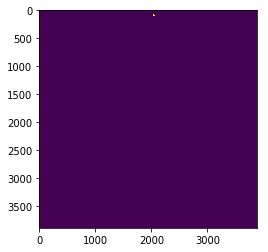

26 (3884, 3892)


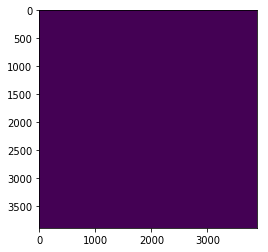

27 (3884, 3892)


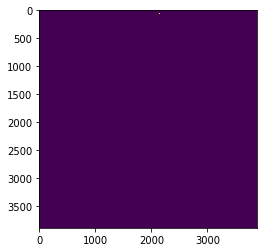

28 (3884, 3892)


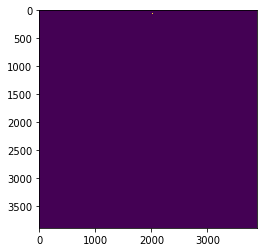

29 (3884, 3892)


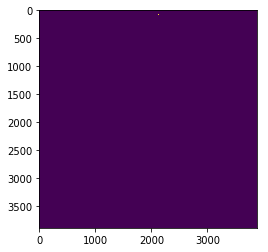

30 (3884, 3892)


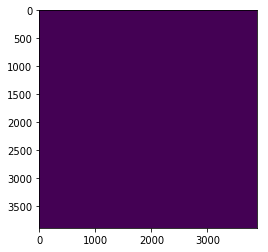

31 (3884, 3892)


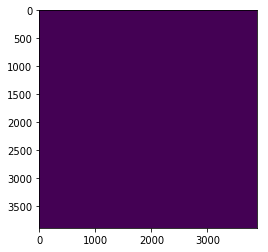

32 (3884, 3892)


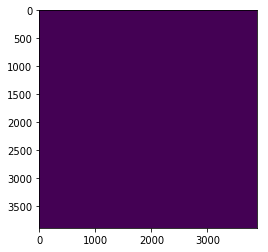

33 (3884, 3892)


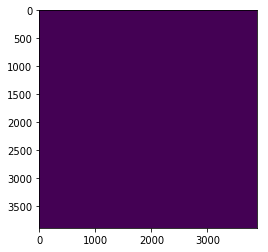

34 (3884, 3892)


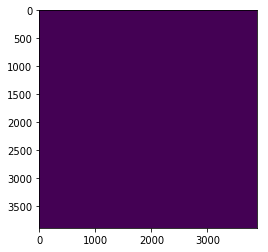

35 (3884, 3892)


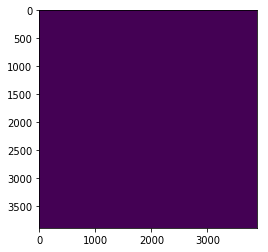

36 (3884, 3892)


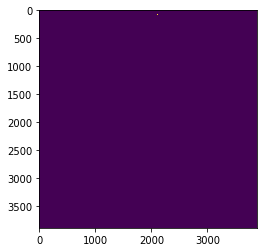

37 (3884, 3892)


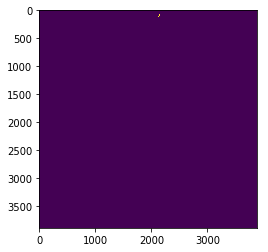

38 (3884, 3892)


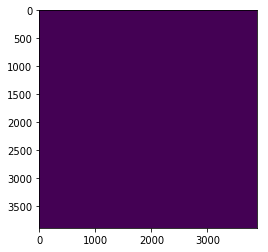

39 (3884, 3892)


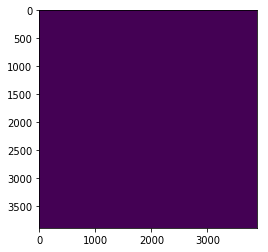

40 (3884, 3892)


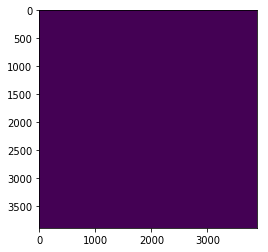

41 (3884, 3892)


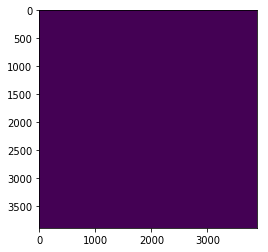

42 (3884, 3892)


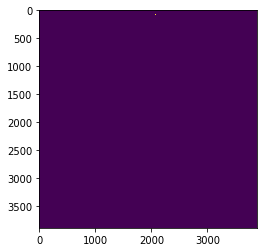

43 (3884, 3892)


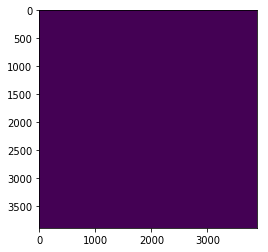

44 (3884, 3892)


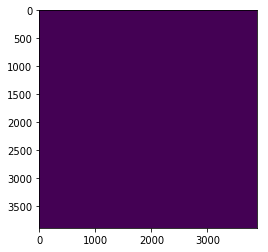

45 (3884, 3892)


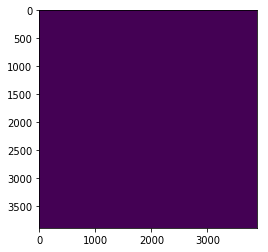

46 (3884, 3892)


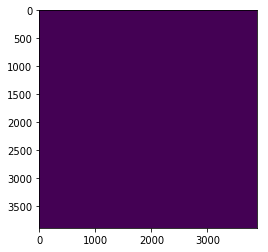

47 (3884, 3892)


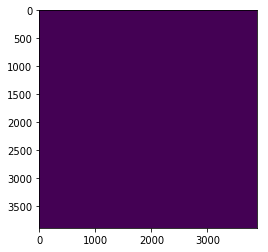

48 (3884, 3892)


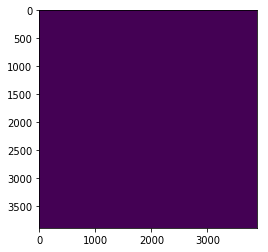

49 (3884, 3892)


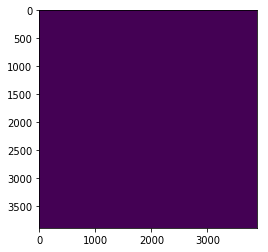

50 (3884, 3892)


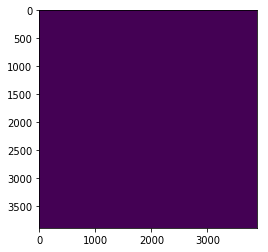

51 (3884, 3892)


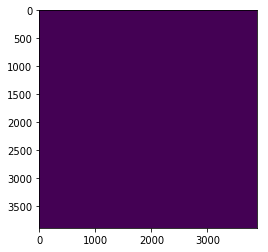

52 (3884, 3892)


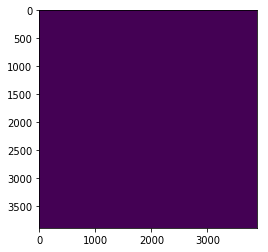

53 (3884, 3892)


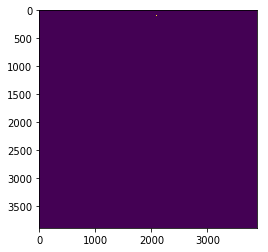

54 (3884, 3892)


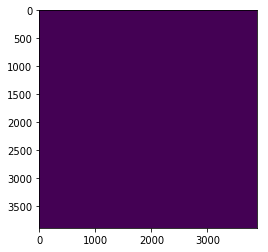

55 (3884, 3892)


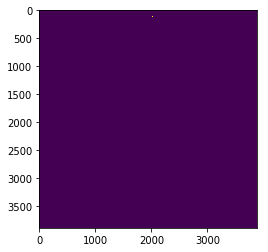

56 (3884, 3892)


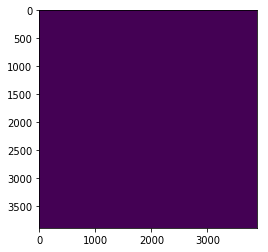

57 (3884, 3892)


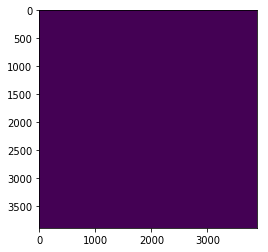

58 (3884, 3892)


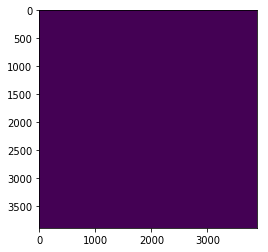

59 (3884, 3892)


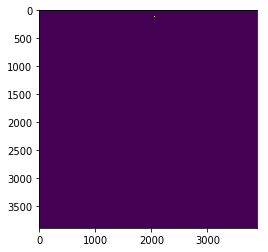

60 (3884, 3892)


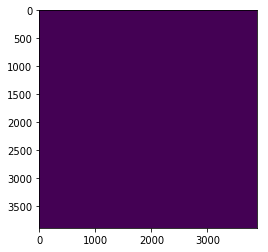

61 (3884, 3892)


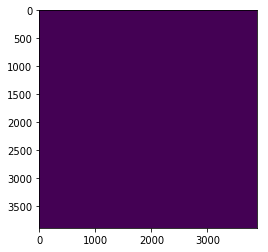

62 (3884, 3892)


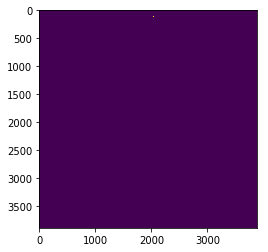

63 (3884, 3892)


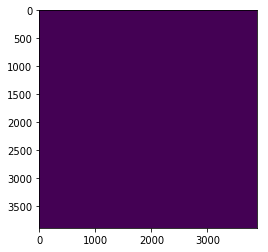

64 (3884, 3892)


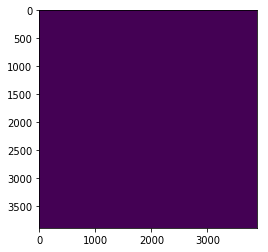

65 (3884, 3892)


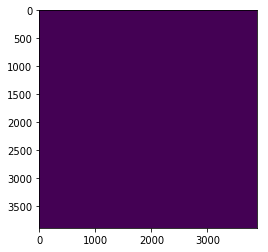

66 (3884, 3892)


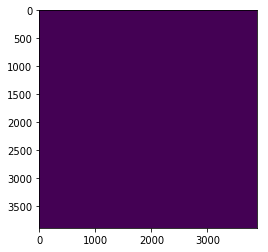

67 (3884, 3892)


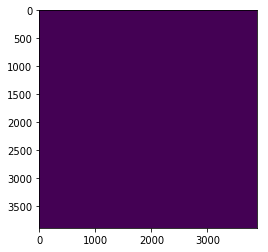

68 (3884, 3892)


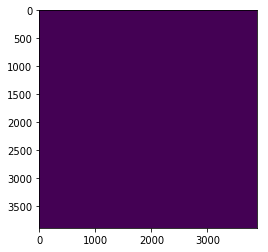

69 (3884, 3892)


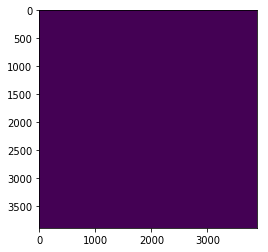

70 (3884, 3892)


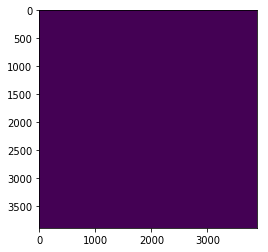

71 (3884, 3892)


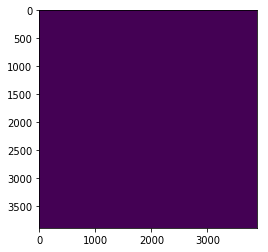

72 (3884, 3892)


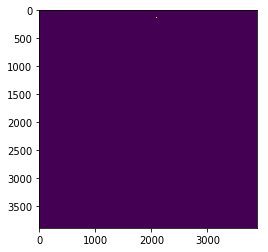

73 (3884, 3892)


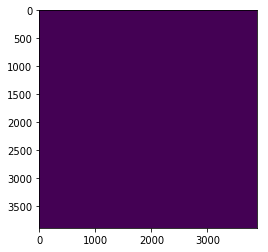

74 (3884, 3892)


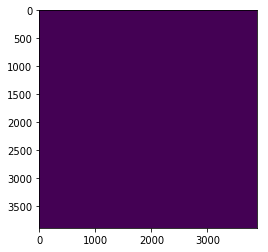

75 (3884, 3892)


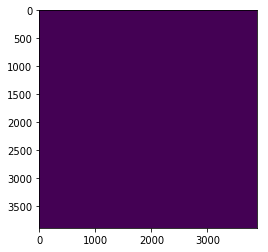

76 (3884, 3892)


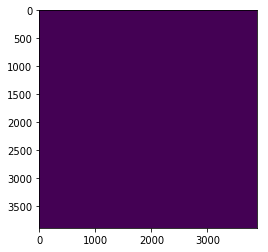

77 (3884, 3892)


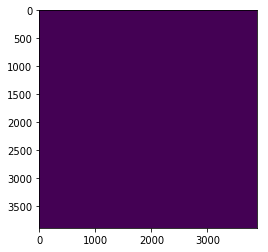

78 (3884, 3892)


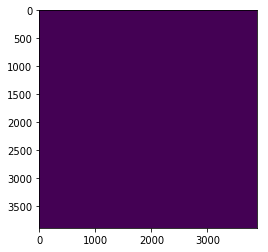

79 (3884, 3892)


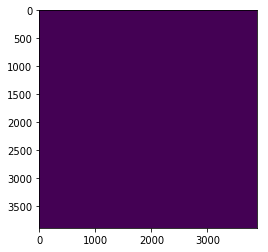

80 (3884, 3892)


KeyboardInterrupt: 

In [41]:
for n, mask in enumerate(mask2):
    print(n, np.asarray(mask).shape)
    plt.imshow(mask)
    plt.show()

In [15]:
img = dataset_test.load_image(1)


In [16]:
img2 = np.rollaxis(img,0,3)
img2.shape


(3884, 3892, 3)

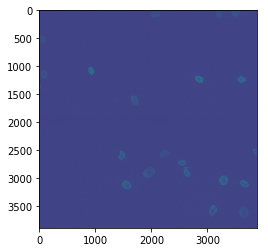

In [17]:
plt.imshow(img[2,:,:])

In [45]:
import PIL
for i in range(50):
    
    mask, class_ids = dataset_test.load_mask(i)
    # print(mask, class_ids)
    # type(mask)
    print(i, "ids={}  shape: {}".format(str(class_ids), mask.shape))
#     mask
#     plt.imshow(mask)
    # img = PIL.Image.fromarray(mask)
    # img

0 ids=[1 1]  shape: (128, 128, 2)
1 ids=[2]  shape: (128, 128, 1)
2 ids=[3]  shape: (128, 128, 1)
3 ids=[3 1 2]  shape: (128, 128, 3)
4 ids=[1 2]  shape: (128, 128, 2)
5 ids=[2 3 2]  shape: (128, 128, 3)
6 ids=[3 3]  shape: (128, 128, 2)
7 ids=[3 1]  shape: (128, 128, 2)
8 ids=[1 3]  shape: (128, 128, 2)
9 ids=[2]  shape: (128, 128, 1)
10 ids=[1 1]  shape: (128, 128, 2)
11 ids=[1 2]  shape: (128, 128, 2)
12 ids=[2 2 2]  shape: (128, 128, 3)
13 ids=[1]  shape: (128, 128, 1)
14 ids=[2 3]  shape: (128, 128, 2)
15 ids=[1]  shape: (128, 128, 1)
16 ids=[3 2]  shape: (128, 128, 2)
17 ids=[1]  shape: (128, 128, 1)
18 ids=[1]  shape: (128, 128, 1)
19 ids=[3]  shape: (128, 128, 1)
20 ids=[1 1 1]  shape: (128, 128, 3)
21 ids=[3 3 1 3]  shape: (128, 128, 4)
22 ids=[2 1]  shape: (128, 128, 2)
23 ids=[1 3]  shape: (128, 128, 2)
24 ids=[1 2]  shape: (128, 128, 2)
25 ids=[3]  shape: (128, 128, 1)
26 ids=[2 2]  shape: (128, 128, 2)
27 ids=[1 1 3]  shape: (128, 128, 3)
28 ids=[2 3]  shape: (128, 128, 2)

In [55]:
mask, class_ids = dataset_test.load_mask(21)
np.set_printoptions(threshold=np.nan)
print(mask[:,:,0])

[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

In [5]:
# Training dataset
dataset_train = imgDataset()
dataset_train.load_shapes(500, config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1])
dataset_train.prepare()

# Validation dataset
dataset_val = imgDataset()
dataset_val.load_shapes(50, config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1])
dataset_val.prepare()

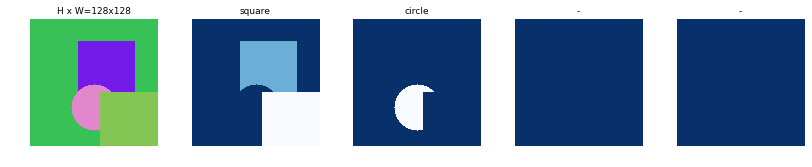

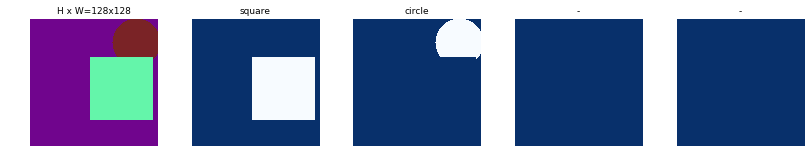

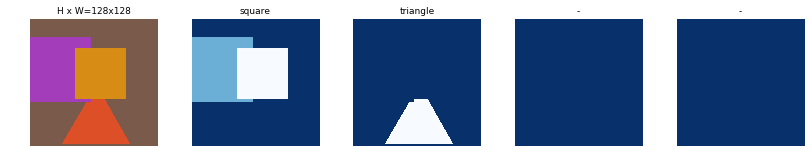

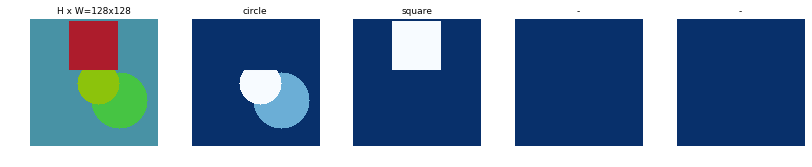

In [6]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

## Ceate Model

In [ ]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

In [7]:
# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last()[1], by_name=True)

## Training

Train in two stages:
1. Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass `layers='heads'` to the `train()` function.

2. Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass `layers="all` to train all layers.

In [8]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=1, 
            layers='heads')

Checkpoint Path:  /deepmatter/mask_rcnn/logs/shapes2017102802/mask_rcnn_{epoch:04d}.h5
Starting at epoch 0. LR=0.002

Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4      

/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/gradients_impl.py:95: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.5/dist-packages/keras/engine/training.py:1987: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/1
100/100 [==============================] - 73s - loss: 2.2164 - rpn_class_loss: 0.0242 - rpn_bbox_loss: 1.0638 - mrcnn_class_loss: 0.2426 - mrcnn_bbox_loss: 0.3006 - mrcnn_mask_loss: 0.2385 - val_loss: 1.8454 - val_rpn_class_loss: 0.0232 - val_rpn_bbox_loss: 0.9971 - val_mrcnn_class_loss: 0.1398 - val_mrcnn_bbox_loss: 0.1343 - val_mrcnn_mask_loss: 0.2042


In [9]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=2, 
            layers="all")

Checkpoint Path:  /deepmatter/mask_rcnn/logs/shapes2017102802/mask_rcnn_{epoch:04d}.h5
Starting at epoch 0. LR=0.0002

Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn3a_branch2b      

/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/gradients_impl.py:95: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.5/dist-packages/keras/engine/training.py:1987: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/1
100/100 [==============================] - 86s - loss: 11.4006 - rpn_class_loss: 0.0184 - rpn_bbox_loss: 0.8409 - mrcnn_class_loss: 0.1576 - mrcnn_bbox_loss: 0.0902 - mrcnn_mask_loss: 0.1977 - val_loss: 11.4376 - val_rpn_class_loss: 0.0220 - val_rpn_bbox_loss: 1.0068 - val_mrcnn_class_loss: 0.1172 - val_mrcnn_bbox_loss: 0.0683 - val_mrcnn_mask_loss: 0.1278


In [10]:
# Save weights
# Typically not needed because callbacks save after every epoch
# Uncomment to save manually
# model_path = os.path.join(MODEL_DIR, "mask_rcnn_shapes.h5")
# model.keras_model.save_weights(model_path)

## Detection

In [11]:
class InferenceConfig(imgConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()[1]

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

original_image           shape: (128, 128, 3)         min:  108.00000  max:  236.00000
image_meta               shape: (12,)                 min:    0.00000  max:  128.00000
gt_bbox                  shape: (2, 5)                min:    2.00000  max:  102.00000
gt_mask                  shape: (128, 128, 2)         min:    0.00000  max:    1.00000


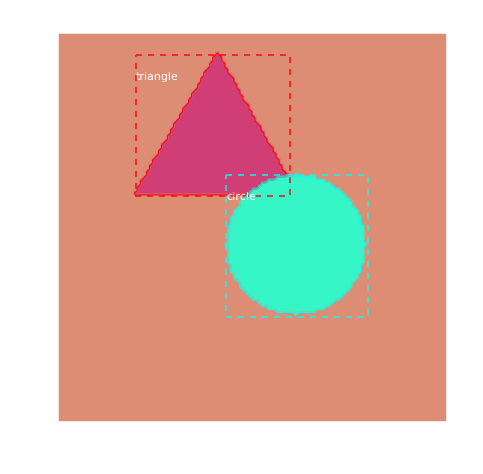

In [12]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_bbox)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

Processing 1 images
image                    shape: (128, 128, 3)         min:  108.00000  max:  236.00000
molded_images            shape: (1, 128, 128, 3)      min:  -15.70000  max:  132.10000
image_metas              shape: (1, 12)               min:    0.00000  max:  128.00000


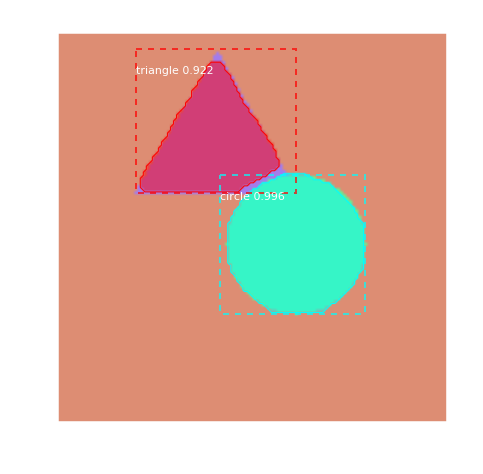

In [13]:
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

## Evaluation

In [14]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_val.image_ids, 10)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id,
                         r["rois"], r["class_ids"], r["scores"])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

mAP:  0.95
